In [121]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import q2_script

In [122]:
x_train, y_train, x_test, y_test = q2_script.read_dataset()
x_train, y_train, x_test, y_test = x_train / 255, y_train, x_test / 255, y_test
# Note: for some reason, when I use the function get_dataset() from q2_script, the images are not normalized
# but when I use read_dataset() at q2_script, the images are normalized. I don't know why. 

x_val = x_train[0:10000]
y_val = y_train[0:10000]

x_train = x_train[10000:]
y_train = y_train[10000:]

In [123]:
# print maxes
print("x_train max: ", np.max(x_train))
print("y_train max: ", np.max(y_train))
print("x_val max: ", np.max(x_val))
print("y_val max: ", np.max(y_val))
print("x_test max: ", np.max(x_test))
print("y_test max: ", np.max(y_test))

x_train max:  1.0
y_train max:  1.0
x_val max:  1.0
y_val max:  1.0
x_test max:  1.0
y_test max:  1.0


In [124]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 784)
y_train shape: (50000, 10)
x_val shape: (10000, 784)
y_val shape: (10000, 10)
x_test shape: (10000, 784)
y_test shape: (10000, 10)


In [204]:
# logistic regression model

class LogisticRegression:
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test, weight_initilisation):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
                
        # add bias
        self.x_train = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
        self.x_val = np.concatenate((np.ones((x_val.shape[0], 1)), x_val), axis=1)
        self.x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)
        
        self.weights = self.initialize_weights(weight_initilisation)
                
    
    def initialize_weights(self, weight_initilisation):
        if weight_initilisation == "normal" or weight_initilisation == "gaussian":
            # normal distribution with mean 0 and variance 1
            self.weights = np.random.normal(loc=0.0, scale=1.0, size=(10, 785))
        elif weight_initilisation == "zeros":
            self.weights = np.zeros((10, 785))
        elif weight_initilisation == "uniform":
            self.weights = np.random.uniform(low=-1, high=1, size=(10, 785))
        else:
            raise Exception("Invalid weight initilisation method, choose from: \"normal\", \"zeros\" or \"uniform\"")
        return self.weights
    
    def softmax(self, z):
        nom = np.exp(z)
        denom = np.sum(np.exp(z), axis=0)
        
        # clip the values to avoid overflow
        upperLim = 1e6
        lowerLim = 1e-6
        nom[nom > upperLim] = upperLim
        nom[nom < lowerLim] = lowerLim
        denom[denom > upperLim] = upperLim
        denom[denom < lowerLim] = lowerLim
        
        return nom / denom
    
    def forward(self, x):
        # get the prediction with the current weights
        z = np.matmul(x, self.weights.T)
        return self.softmax(z)
    
    def train(self, epochs, lr, batch_size, L2_regularisation_coeff):
        # epochs: number of iterations
        # lr: learning rate
        # batch_size: size of mini-batch
        # L2_regularisation_coeff: lambda
        vals = []
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1} of {epochs}")
            for i in range(0, len(self.x_train), batch_size):
                x_batch = self.x_train[i:i + batch_size]
                y_batch = self.y_train[i:i + batch_size]
                self.update_weights(x_batch, y_batch, lr, L2_regularisation_coeff)
            vals.append(self.evaluate())
        return vals
    
       
    def update_weights(self, x_batch, y_batch, lr, L2_regularisation_coeff):
        upperLim = 1e6
        lowerLim = -1e6
        y_pred = self.forward(x_batch)
        grad = np.matmul((y_pred - y_batch).T, x_batch) + L2_regularisation_coeff * self.weights
        # clip the gradient to avoid overflow
        grad[grad > upperLim] = upperLim
        grad[grad < lowerLim] = lowerLim
        
        # update the weights
        self.weights -= lr * grad
        
        # clip the weights to avoid overflow
        self.weights[self.weights > upperLim] = upperLim
        self.weights[self.weights < lowerLim] = lowerLim
    
    def evaluate(self):
        # get the prediction
        y_pred = self.forward(self.x_val)
        # number of correct predictions
        correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(self.y_val, axis=1))
        print(f"Validation accuracy: {correct / len(self.x_val)}")
        return correct / len(self.x_val)
    
    def test(self):
        # get the prediction
        y_pred = self.forward(self.x_test)
        correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(self.y_test, axis=1))
        print(f"Test accuracy: {correct / len(self.x_test)}")
        
        # confusion matrix
        confusion_matrix = np.zeros((10, 10))
        for i in range(len(self.x_test)):
            confusion_matrix[np.argmax(y_pred[i]), np.argmax(self.y_test[i])] += 1
        print("Confusion matrix:")
        print(confusion_matrix)

        

In [126]:
logistic_regression = LogisticRegression(x_train, y_train, x_val, y_val, x_test, y_test, "gaussian")
logistic_regression.train(epochs=100, lr=5e-4, batch_size=200, L2_regularisation_coeff=1e-4)

Epoch 1 of 100
Validation accuracy: 0.6083
Epoch 2 of 100
Validation accuracy: 0.7123
Epoch 3 of 100
Validation accuracy: 0.7591
Epoch 4 of 100
Validation accuracy: 0.7875
Epoch 5 of 100
Validation accuracy: 0.8057
Epoch 6 of 100
Validation accuracy: 0.8209
Epoch 7 of 100
Validation accuracy: 0.8314
Epoch 8 of 100
Validation accuracy: 0.8393
Epoch 9 of 100
Validation accuracy: 0.844
Epoch 10 of 100
Validation accuracy: 0.8493
Epoch 11 of 100
Validation accuracy: 0.8525
Epoch 12 of 100
Validation accuracy: 0.8568
Epoch 13 of 100
Validation accuracy: 0.8591
Epoch 14 of 100
Validation accuracy: 0.8613
Epoch 15 of 100
Validation accuracy: 0.8627
Epoch 16 of 100
Validation accuracy: 0.8648
Epoch 17 of 100
Validation accuracy: 0.8662
Epoch 18 of 100
Validation accuracy: 0.8673
Epoch 19 of 100
Validation accuracy: 0.8682
Epoch 20 of 100
Validation accuracy: 0.8698
Epoch 21 of 100
Validation accuracy: 0.8709
Epoch 22 of 100
Validation accuracy: 0.8722
Epoch 23 of 100
Validation accuracy: 0.872

In [127]:
testAcc = logistic_regression.test()

Test accuracy: 0.8979
Confusion matrix:
[[9.510e+02 0.000e+00 1.000e+01 7.000e+00 1.000e+00 1.000e+01 1.400e+01
  5.000e+00 1.300e+01 9.000e+00]
 [0.000e+00 1.101e+03 1.200e+01 1.000e+00 2.000e+00 1.000e+00 3.000e+00
  5.000e+00 1.300e+01 8.000e+00]
 [1.000e+00 5.000e+00 8.940e+02 2.400e+01 7.000e+00 2.000e+00 7.000e+00
  1.700e+01 1.000e+01 2.000e+00]
 [5.000e+00 1.000e+00 2.600e+01 9.000e+02 5.000e+00 4.000e+01 2.000e+00
  1.100e+01 2.600e+01 1.000e+01]
 [0.000e+00 0.000e+00 8.000e+00 1.000e+00 8.950e+02 1.300e+01 1.400e+01
  1.500e+01 1.200e+01 4.700e+01]
 [1.000e+01 7.000e+00 1.000e+01 3.200e+01 6.000e+00 7.610e+02 2.700e+01
  5.000e+00 5.600e+01 1.500e+01]
 [8.000e+00 4.000e+00 1.000e+01 5.000e+00 8.000e+00 1.700e+01 8.830e+02
  1.000e+00 1.100e+01 0.000e+00]
 [4.000e+00 0.000e+00 1.500e+01 7.000e+00 3.000e+00 8.000e+00 1.000e+00
  9.260e+02 1.700e+01 4.200e+01]
 [1.000e+00 1.600e+01 4.300e+01 2.300e+01 9.000e+00 3.100e+01 7.000e+00
  8.000e+00 8.050e+02 1.300e+01]
 [0.000e+00 1.0

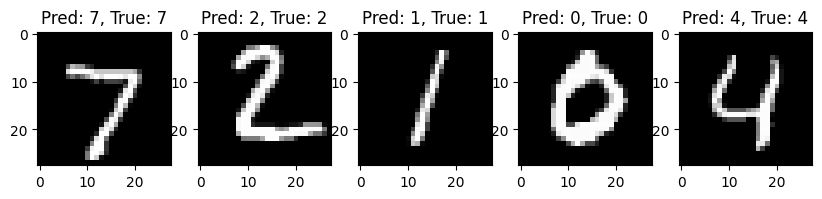

In [128]:
images = x_test[:5]
images_with_bias = np.concatenate((np.ones((images.shape[0], 1)), images), axis=1)
y_pred = logistic_regression.forward(images_with_bias)
pred = np.argmax(y_pred, axis=1)
label = np.argmax(y_test[:5], axis=1)
# display the first 5 images with their predicted and true labels side by side
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    # plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {pred[i]}, True: {label[i]}")

plt.show()


Epoch 1 of 10
Validation accuracy: 0.1001
Epoch 2 of 10
Validation accuracy: 0.1001
Epoch 3 of 10
Validation accuracy: 0.1001
Epoch 4 of 10
Validation accuracy: 0.1001
Epoch 5 of 10
Validation accuracy: 0.1001
Epoch 6 of 10
Validation accuracy: 0.1001
Epoch 7 of 10
Validation accuracy: 0.1001
Epoch 8 of 10
Validation accuracy: 0.1001
Epoch 9 of 10
Validation accuracy: 0.1001
Epoch 10 of 10
Validation accuracy: 0.1001
Epoch 1 of 10
Validation accuracy: 0.8367
Epoch 2 of 10
Validation accuracy: 0.8609
Epoch 3 of 10
Validation accuracy: 0.8719
Epoch 4 of 10
Validation accuracy: 0.8791
Epoch 5 of 10
Validation accuracy: 0.8835
Epoch 6 of 10
Validation accuracy: 0.8853
Epoch 7 of 10
Validation accuracy: 0.8876
Epoch 8 of 10
Validation accuracy: 0.8895
Epoch 9 of 10
Validation accuracy: 0.8921
Epoch 10 of 10
Validation accuracy: 0.893
Epoch 1 of 10
Validation accuracy: 0.6663
Epoch 2 of 10
Validation accuracy: 0.8246
Epoch 3 of 10
Validation accuracy: 0.8498
Epoch 4 of 10
Validation accuracy

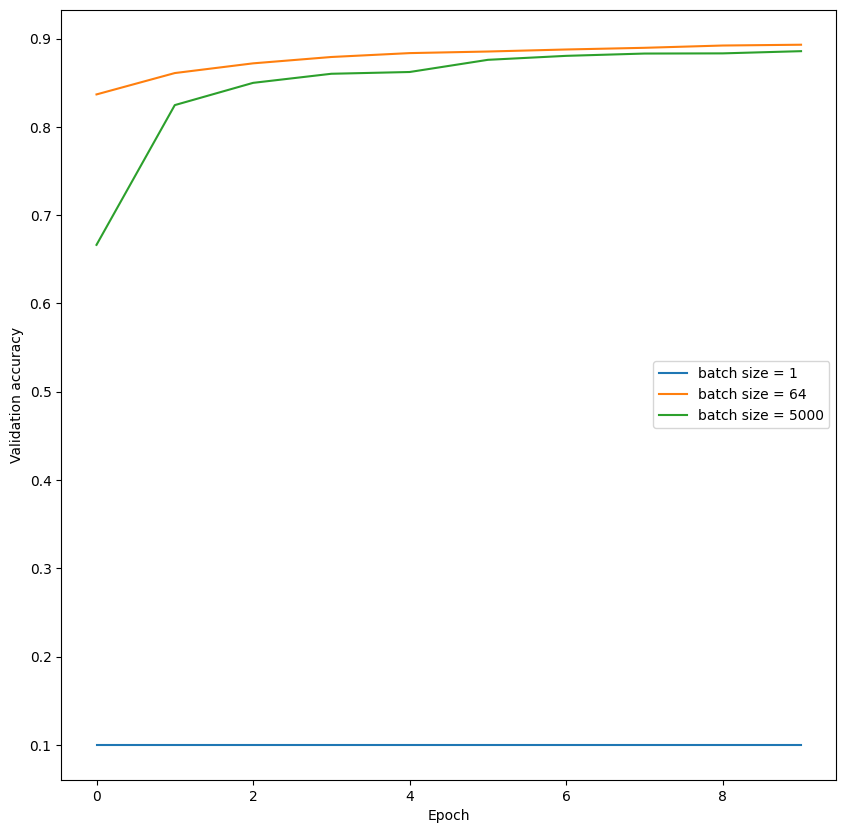

In [208]:
# run the model with batch sizes 1, 64 and 5000 and plot the validation accuracy vs epoch as 3 lines on the same plot
vals = []
for i in range(3):
    if i == 0:
        batch_size = 1
    elif i == 1:
        batch_size = 64
    else:
        batch_size = 5000
    myModel = LogisticRegression(x_train, y_train, x_val, y_val, x_test, y_test, "zeros")
    vals.append(myModel.train(epochs=10, lr=5e-4, batch_size=batch_size, L2_regularisation_coeff=1e-4))
        
plt.figure(figsize=(10, 10))
plt.plot(vals[0], label="batch size = 1")
plt.plot(vals[1], label="batch size = 64")
plt.plot(vals[2], label="batch size = 5000")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.show()


In [207]:
vals[0]

0.1001

In [209]:
best_model = LogisticRegression(x_train, y_train, x_val, y_val, x_test, y_test, "zeros")
best_model.train(epochs=100, lr=1e-3, batch_size=64, L2_regularisation_coeff=1e-4)

Epoch 1 of 100
Validation accuracy: 0.8602
Epoch 2 of 100
Validation accuracy: 0.8761
Epoch 3 of 100
Validation accuracy: 0.8857
Epoch 4 of 100
Validation accuracy: 0.8893
Epoch 5 of 100
Validation accuracy: 0.8921
Epoch 6 of 100
Validation accuracy: 0.8939
Epoch 7 of 100
Validation accuracy: 0.8955
Epoch 8 of 100
Validation accuracy: 0.8982
Epoch 9 of 100
Validation accuracy: 0.8989
Epoch 10 of 100
Validation accuracy: 0.9006
Epoch 11 of 100
Validation accuracy: 0.9014
Epoch 12 of 100
Validation accuracy: 0.903
Epoch 13 of 100
Validation accuracy: 0.9035
Epoch 14 of 100
Validation accuracy: 0.9042
Epoch 15 of 100
Validation accuracy: 0.9044
Epoch 16 of 100
Validation accuracy: 0.905
Epoch 17 of 100
Validation accuracy: 0.9057
Epoch 18 of 100
Validation accuracy: 0.9064
Epoch 19 of 100
Validation accuracy: 0.9068
Epoch 20 of 100
Validation accuracy: 0.9076
Epoch 21 of 100
Validation accuracy: 0.9083
Epoch 22 of 100
Validation accuracy: 0.9087
Epoch 23 of 100
Validation accuracy: 0.9086

[0.8602,
 0.8761,
 0.8857,
 0.8893,
 0.8921,
 0.8939,
 0.8955,
 0.8982,
 0.8989,
 0.9006,
 0.9014,
 0.903,
 0.9035,
 0.9042,
 0.9044,
 0.905,
 0.9057,
 0.9064,
 0.9068,
 0.9076,
 0.9083,
 0.9087,
 0.9086,
 0.9087,
 0.9093,
 0.9094,
 0.9097,
 0.9099,
 0.91,
 0.9101,
 0.9106,
 0.9103,
 0.9106,
 0.9108,
 0.9107,
 0.911,
 0.9116,
 0.9118,
 0.912,
 0.9128,
 0.9128,
 0.9132,
 0.9131,
 0.9132,
 0.913,
 0.9132,
 0.9135,
 0.9139,
 0.9141,
 0.914,
 0.9139,
 0.9139,
 0.914,
 0.9139,
 0.9139,
 0.9138,
 0.9138,
 0.9137,
 0.9138,
 0.9138,
 0.9139,
 0.9139,
 0.9138,
 0.9139,
 0.9138,
 0.9136,
 0.9137,
 0.9135,
 0.9139,
 0.9139,
 0.9139,
 0.914,
 0.9141,
 0.9143,
 0.9143,
 0.9144,
 0.9145,
 0.9144,
 0.9144,
 0.9148,
 0.9148,
 0.915,
 0.9149,
 0.9149,
 0.9146,
 0.9149,
 0.9149,
 0.915,
 0.915,
 0.9151,
 0.9152,
 0.9152,
 0.9151,
 0.9152,
 0.9152,
 0.9152,
 0.9152,
 0.9152,
 0.9153,
 0.9153]

In [210]:
best_model.test()

Test accuracy: 0.9164
Confusion matrix:
[[9.600e+02 0.000e+00 1.200e+01 5.000e+00 1.000e+00 1.100e+01 1.200e+01
  4.000e+00 1.200e+01 8.000e+00]
 [0.000e+00 1.108e+03 1.200e+01 1.000e+00 1.000e+00 3.000e+00 2.000e+00
  8.000e+00 1.400e+01 9.000e+00]
 [1.000e+00 2.000e+00 9.030e+02 1.900e+01 5.000e+00 0.000e+00 6.000e+00
  2.100e+01 6.000e+00 1.000e+00]
 [2.000e+00 2.000e+00 2.100e+01 9.100e+02 2.000e+00 2.700e+01 2.000e+00
  5.000e+00 2.200e+01 1.100e+01]
 [0.000e+00 1.000e+00 9.000e+00 1.000e+00 9.100e+02 1.000e+01 8.000e+00
  8.000e+00 1.400e+01 2.600e+01]
 [6.000e+00 3.000e+00 6.000e+00 2.900e+01 2.000e+00 7.880e+02 2.700e+01
  3.000e+00 4.100e+01 1.200e+01]
 [5.000e+00 4.000e+00 1.200e+01 4.000e+00 6.000e+00 1.500e+01 8.980e+02
  1.000e+00 1.100e+01 0.000e+00]
 [3.000e+00 1.000e+00 1.100e+01 1.000e+01 1.000e+00 6.000e+00 1.000e+00
  9.360e+02 6.000e+00 1.700e+01]
 [1.000e+00 1.300e+01 4.100e+01 1.900e+01 7.000e+00 2.200e+01 2.000e+00
  3.000e+00 8.340e+02 8.000e+00]
 [2.000e+00 1.0

(10, 784)


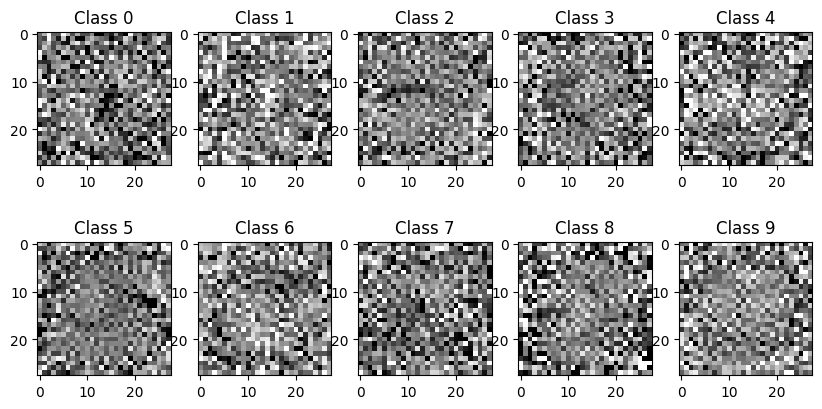

In [213]:
# remove bias from weights
weight = logistic_regression.weights[:, 1:]
print(weight.shape)

# display the weights for each class using matshow
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weight[i].reshape(28, 28), cmap=plt.cm.gray, vmin=0.5*weight[i].min(), vmax=0.5*weight[i].max())
    plt.title(f"Class {i}")


In [214]:
y_pred = best_model.forward(best_model.x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(best_model.y_test, axis=1)
precision = np.zeros(10)
recall = np.zeros(10)
F1 = np.zeros(10)
F2 = np.zeros(10)

for i in range(10):
    TP = np.sum((y_pred == i) & (y_true == i))
    FP = np.sum((y_pred == i) & (y_true != i))
    FN = np.sum((y_pred != i) & (y_true == i))
    precision[i] = TP / (TP + FP)
    recall[i] = TP / (TP + FN)
    F1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    F2[i] = 5 * precision[i] * recall[i] / (4 * precision[i] + recall[i])

barrier = "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
print(f"{barrier}\n Precision: \n{precision} \n{barrier}\n Recall: \
      \n{recall} \n{barrier}\n  F1: \n{F1} \n{barrier}\n  F2: \n{F2}\n{barrier}")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Precision: 
[0.93658537 0.95682211 0.93672199 0.9063745  0.92198582 0.85932388
 0.93933054 0.94354839 0.87789474 0.87583572] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Recall:       
[0.97959184 0.97621145 0.875      0.9009901  0.92668024 0.88340807
 0.93736952 0.91050584 0.85626283 0.90882061] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  F1: 
[0.95760599 0.96641954 0.90480962 0.90367428 0.92432707 0.87119956
 0.93834901 0.92673267 0.86694387 0.89202335] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  F2: 
[0.97067745 0.97227097 0.886685   0.90206186 0.92573754 0.87848384
 0.93776107 0.9169279  0.86050351 0.90202636]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
